---
title: Implementing Logistic Regression
author: Evan Flaks
date: '2025-04-08'
image: "logistic.jpeg"
description: "Implementing Gradient Descent for Logistic Regression and Performing Data Experiments with Varying Momentum"
format: html
---

# Abstract

In [2]:
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

# Part A: Implementing Logistic Regression

In my [logistic.py](https://github.com/evanflaks/evanflaks.github.io/blob/main/posts/logistic/logistic.py) script, I have implemented a few classes to perform logistic regression on a data set. 

The <code>LinearModel</code> class provides the foundation for linear models by maintaining a weight vector $w$ and defining core functionality to compute scores and predictions. The <code>score</code>  method calculates the raw output (dot product) for each data point in the feature matrix $X$ by multiplying it with the model's weight vector $w$. If $w$ has not been initialized yet, it randomly initializes it to a vector of the correct shape. The <code>predict</code>  method then uses these scores to produce binary predictions by thresholding the score at zero; any value greater than zero becomes a <code>1.0</code> , otherwise <code>0.0</code>.

The <code>LogisticRegression</code> class inherits from <code>LinearModel</code> and implements functionality specific to binary classification using the logistic loss. It introduces a loss method that calculates the average logistic loss over the dataset by applying the sigmoid function to the model's scores to obtain probabilities, and then computing the cross-entropy loss with the true labels y. The <code>grad</code> method computes the gradient of this loss with respect to the weight vector $w$, which is necessary for optimization. It does this by taking the derivative of the loss function, resulting in the formula 
$$\frac{1}{n} \cdot X^{T} @ (\sigma(a)-y)$$
Where $\sigma(s)$ is the vector of predicted probabilities. These methods enable learning the optimal weights for classification tasks through gradient-based updates.

The <code>GradientDescentOptimizer</code> class is responsible for updating the model's weights using gradient descent with momentum. Initialized with a reference to a model (e.g., <code>LogisticRegression</code>), it keeps track of the previous weight vector to compute the momentum term. The <code>step</code> method performs a single optimization step using the formula
$$w_{k+1} = w_k - \alpha \cdot \nabla L(w_k) + \beta(w_k -w_{k-1})$$
Where $\alpha$ is the learning rate and $\beta$ is the momentum coefficient. If it’s the first step, the previous weight vector is simply initialized to the current weights. The momentum term helps smooth out updates and can accelerate convergence, especially in cases where the loss surface has narrow valleys or noisy gradients.

# Part B: Experiments

Below is I have written a few functions that will allow us to perform and vizualize various experiments. 

The <code>run_experiment</code> function runs a logistic regression training loop using gradient descent with a specified learning rate (<code>alpha</code>) and momentum parameter (<code>beta</code>) for a set number of <code>iterations</code>. It initializes a <code>LogisticRegression</code> model and a <code>GradientDescentOptimizer</code>. During each iteration, the function computes the current loss and performs a gradient descent step using the specified parameters. The loss at each iteration is stored in a list, allowing for later analysis of convergence behavior. It returns both the loss history and the trained model.

The <code>plot_decision_boundary</code> function visualizes the decision boundary learned by a trained logistic regression model over a 2D feature space. It first defines a grid of (x, y) coordinates that spans the input data range and constructs a feature matrix that includes a bias term. It then uses the model to compute sigmoid probabilities over this grid and reshapes the results for contour plotting. The function plots a contour at the decision threshold (probability = 0.5), which represents the decision boundary. It overlays this boundary on a scatter plot of the original dataset, clearly showing how well the model separates the two classes.

The <code>plot_loss_curve</code> function plots the progression of logistic loss values recorded during the training process. It takes a list of loss values (one per iteration) and creates a line plot with iteration number on the x-axis and logistic loss on the y-axis. The resulting graph helps visualize whether the loss is decreasing consistently—a key indicator of successful convergence during training. A smooth, monotonically decreasing curve suggests that the gradient descent algorithm is working correctly.


In [3]:
def run_experiment(X, y, beta, alpha, iterations):
    """
    Run gradient descent on the provided classification data for a given beta (momentum)
    and learning rate alpha, returning the loss history and final model.
    """
    model = LogisticRegression()
    optimizer = GradientDescentOptimizer(model)
    losses = []
    for i in range(iterations):
        loss = model.loss(X, y).item()
        losses.append(loss)
        optimizer.step(X, y, alpha=alpha, beta=beta)
    return losses, model

# === Visualization Functions ===

def plot_decision_boundary(model, X, y):
    """
    Plot the decision boundary learned by the model along with the data.
    We compute the sigmoid outputs on a grid and then plot a contour where
    the decision boundary (σ(s)=0.5) lies.
    """
    plt.figure(figsize=(8,6))
    
    # Determine grid boundaries
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    
    # Create a meshgrid of points covering the input space
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), 
                            torch.linspace(y_min, y_max, 100), indexing='xy')
    # Note: bias term is 1 for all grid points
    grid = torch.stack([xx.reshape(-1), yy.reshape(-1), torch.ones(xx.numel())], dim=1)
    
    # Compute probabilities on the grid
    probs = torch.sigmoid(model.score(grid)).reshape(xx.shape)
    
    # Plot contour at probability 0.5 (decision boundary)
    plt.contourf(xx, yy, probs.detach().numpy(), levels=[0, 0.5, 1], alpha=0.3, cmap='gray')
    plt.contour(xx, yy, probs.detach().numpy(), levels=[0.5], colors='black')
    
    # Scatter plot of original data
    plt.scatter(X[:,0][y==0], X[:,1][y==0], label="Class 0", edgecolor='k')
    plt.scatter(X[:,0][y==1], X[:,1][y==1], label="Class 1", edgecolor='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary after Training (Vanilla Gradient Descent)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss_curve(losses):
    """
    Plot the loss value as a function of iterations.
    A monotonically decreasing curve is expected for a converging algorithm.
    """
    plt.figure(figsize=(8,6))
    plt.plot(losses, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Logistic Loss")
    plt.title("Loss over Gradient Descent Iterations (Vanilla Gradient Descent)")
    plt.grid(True)
    plt.show()

### Experiment 1: Vanilla Gradient Descent ($\beta=0$)

First let's create some sample data to work with by running the following code

In [4]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

Now we want to run a gradient descent for logistic regression with $\alpha=0.1$ and $\beta=0$, i.e no momentum. The code below runs my <code>run_experiment</code> function with those values and the above synthetic data, plotting the decision boundary for classification after training and the loss over the course of iterations. 

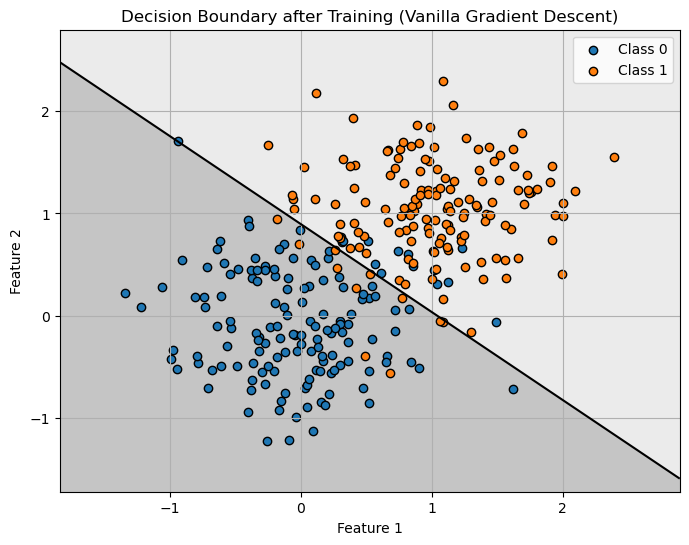

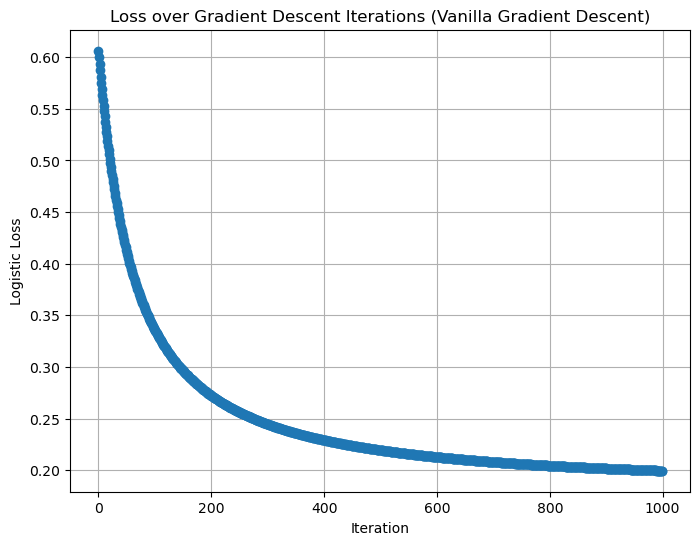

In [6]:
iterations = 1000
alpha = 0.1

# Vanilla GD (β = 0)
losses_vanilla, model_vanilla = run_experiment(X, y, beta=0.0, alpha=alpha, iterations=iterations)
plot_decision_boundary(model_vanilla, X, y)
plot_loss_curve(losses_vanilla)

As we can see from the first graph, the gradient ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍descent ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍for ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍logistic ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍regression ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍converges ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍weight ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍vector ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍$w$
 ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍that ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍looks ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍visually ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍correct, as it is mostly separating the blue data from the red data correctly. 

As we can from the second graph, the loss decreases monotonically over the course of the iterations. 

### Experiment 2: Gradient Descent with Momentum ($\beta = 0.9$)

Now we want to use the same data set as we did in the first experiment, but this time we will implement momentum, setting $\beta=0.9$. The code below runs the experiemnt on the same data but with $\beta=0.9$ and $\alpha=0.1$ still.

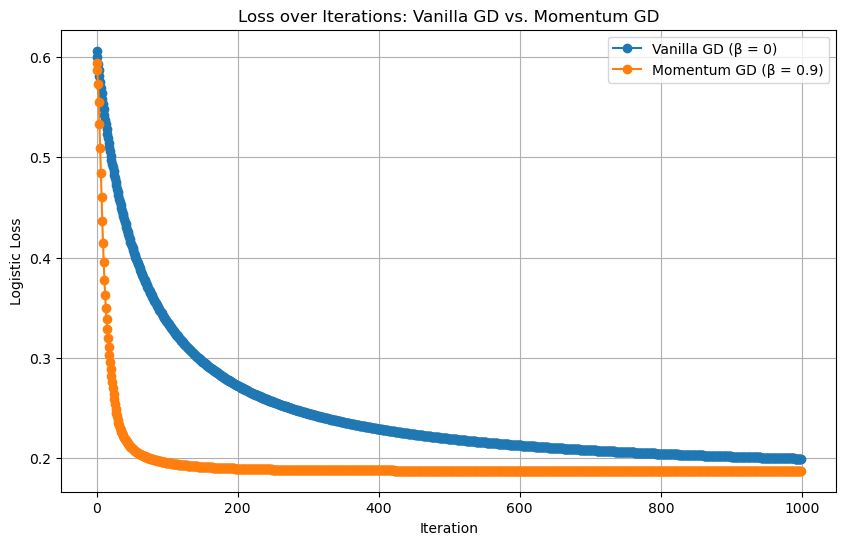

In [9]:
iterations = 1000
alpha = 0.1

# Gradient Descent with momentum (β = 0.9)
losses_momentum, model_momentum = run_experiment(X, y, beta=0.9, alpha=alpha, iterations=iterations)

# Plotting the Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(losses_vanilla, marker='o', label="Vanilla GD (β = 0)")
plt.plot(losses_momentum, marker='o', label="Momentum GD (β = 0.9)")
plt.xlabel("Iteration")
plt.ylabel("Logistic Loss")
plt.title("Loss over Iterations: Vanilla GD vs. Momentum GD")
plt.legend()
plt.grid(True)
plt.show()

As we can see by the plot, gradient descent with momention can converge to the correct weight vector (minimal loss) in fewer iterations than vanilla gradient descent. 

### Experiment 3: Overfitting

Now we want to test Linear Regression on data with more than two dimensions. The code below generates and trains a logistic regression model on synthetic high-dimensional data using vanilla gradient descent. The generate_high_dim_data function creates a dataset with 50 data points (n_points) and 100 features (p_dim). Each data point has p_dim - 1 features sampled from a standard normal distribution, and a final feature of constant ones is appended as a bias term. Labels (y) are randomly assigned as 0 or 1 with equal probability. Two separate datasets are generated: one for training and one for testing. A logistic regression model is then trained on the training data using a custom GradientDescentOptimizer, which performs 200 iterations of optimization with a learning rate (alpha) of 0.1 and no momentum (beta = 0.0). During training, the loss is recorded at each iteration. Finally, the model's predictions are evaluated on both the training and test sets, and the corresponding accuracies are printed.

In [14]:
def generate_high_dim_data(n_points=50, p_dim=100):
    """
    Generates a dataset with n_points data and p_dim features.
    The first (p_dim - 1) features are drawn from a standard normal distribution,
    and the last column is a constant bias (ones).
    Labels are randomly assigned (0 or 1) with equal probability.
    """
    # p_dim includes the bias column.
    X_raw = torch.randn(n_points, p_dim - 1)
    bias = torch.ones(n_points, 1)
    X = torch.cat([X_raw, bias], dim=1)
    y = torch.randint(0, 2, (n_points,)).float()
    return X, y

# Generate the two datasets independently but with the same parameters.
X_train, y_train = generate_high_dim_data(n_points=50, p_dim=100)
X_test, y_test = generate_high_dim_data(n_points=50, p_dim=100)

# === Training the Logistic Regression Model ===

model = LogisticRegression()
optimizer = GradientDescentOptimizer(model)

num_iterations = 200
train_losses = []

for i in range(num_iterations):
    loss = model.loss(X_train, y_train)
    train_losses.append(loss.item())
    # Vanilla gradient descent (beta = 0).
    optimizer.step(X_train, y_train, alpha=0.1, beta=0.0)

# === Evaluate the Model on Training and Test Data ===

train_preds = model.predict(X_train)
train_accuracy = (train_preds == y_train).float().mean().item()

test_preds = model.predict(X_test)
test_accuracy = (test_preds == y_test).float().mean().item()

print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Training Accuracy: 100.00%
Test Accuracy: 48.00%


As we can see, while the Logistic Regression classified the data with 100% accuracy on the training set, it only performed with 48% accuracy on the test set. This suggests that the model has overfit the training data—essentially memorizing the patterns in the training set rather than learning generalizable features. Since the dataset is high-dimensional (with 100 features and only 50 data points), the model has enough flexibility to perfectly separate the training points. However, this does not translate to good performance on unseen data, which explains the low accuracy on the test set.

### Experiment 4: Performance on Empirical Data

Now we want to test our implementation of Logistic Algorithm on real-world, empirical data. From Kaggle, I found a data set on diabetes on other physical metrics created by [GeeksForGeeks](https://x.com/geeksforgeeks?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor). The link to the data set can be found [here](https://www.kaggle.com/datasets/krishu22/diabetes-dataset). The dataset includes key metrics necessary for predictins diabetes such as age, glucose levels, insulin, BMI, etc.  

My goal is train a Logistic Regression model to predict/classify whether a student passed or failed their final exam based on the academic data.

I downloaded the data as a .csv file, now I must read it into a data frame.

In [15]:
import pandas as pd

df = pd.read_csv('/Users/evanflaks/Downloads/diabetes-dataset.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Now we prepare our dataset for logistic regression. First, it separates the feature matrix X from the binary target variable y (which indicates whether a person has diabetes). It then standardizes the features using StandardScaler to ensure each has a mean of 0 and standard deviation of 1, which helps the model train more effectively. A column of ones is appended to the feature matrix to act as a bias (intercept) term. Finally, both the feature matrix and target vector are converted into PyTorch tensors to be used in training a logistic regression model.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch

# Split features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add bias column (intercept term)
import numpy as np
X_scaled = np.hstack([X_scaled, np.ones((X_scaled.shape[0], 1))])

# Convert to torch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)


Now we split our data into training, validation, and testing sets, with a 60%, 20%, and 20% split. 

In [17]:
# First: split into 80% train_val and 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Then split train_val into 60% train and 20% val => 0.25 * 0.8 = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


This function trains a logistic regression model using gradient descent with optional momentum. It takes the model, optimizer, training and validation data, and hyperparameters like the number of iterations <code>(n_iter)</code>, learning rate <code>(alpha)</code>, and momentum <code>(beta)</code>. Before training begins, it calls model.score(X_train) to ensure the model’s weights are initialized. In each iteration of training, the optimizer updates the model weights, and the function records the loss on both the training and validation sets. After all iterations, it returns two lists containing the training and validation losses over time, which will be used to visualize the model’s learning progress.

In [18]:
def train(model, optimizer, X_train, y_train, X_val, y_val, n_iter=100, alpha=0.1, beta=0.0):
    train_losses = []
    val_losses = []

    # 🔧 Force initialization of model.w before optimizer.step()
    model.score(X_train)

    for i in range(n_iter):
        optimizer.step(X_train, y_train, alpha, beta)
        train_loss = model.loss(X_train, y_train).item()
        val_loss = model.loss(X_val, y_val).item()
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses


The code below trains two logistic regression models—one using standard gradient descent and the other using gradient descent with momentum—and compares their performance by plotting the training and validation loss over 100 iterations. It first initializes and trains model1 without momentum ($\beta = 0.0$), then initializes and trains model2 with momentum ($\beta = 0.9$). The recorded loss values for both models are plotted using Matplotlib.

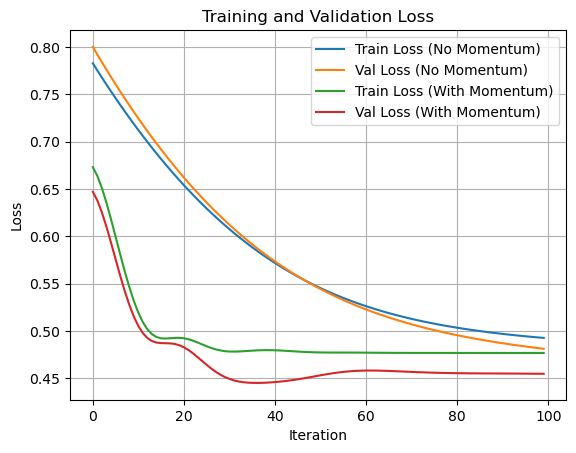

In [19]:
import matplotlib.pyplot as plt

# Without momentum
model1 = LogisticRegression()
optimizer1 = GradientDescentOptimizer(model1)
train1, val1 = train(model1, optimizer1, X_train, y_train, X_val, y_val, n_iter=100, alpha=0.1, beta=0.0)

# With momentum
model2 = LogisticRegression()
optimizer2 = GradientDescentOptimizer(model2)
train2, val2 = train(model2, optimizer2, X_train, y_train, X_val, y_val, n_iter=100, alpha=0.1, beta=0.9)

# Plotting
plt.plot(train1, label='Train Loss (No Momentum)')
plt.plot(val1, label='Val Loss (No Momentum)')
plt.plot(train2, label='Train Loss (With Momentum)')
plt.plot(val2, label='Val Loss (With Momentum)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Similar to our earlier experiment, in both the validation and training sets, loss monotonically decreases over the course of iterations. For both sets, the decrease is more rapid with Momentum, leveling out earlier. Without momentum, loss decreases more gradually but eventually reaches similar loss levels as the models with momentum.

In [20]:
def accuracy(model, X, y):
    preds = model.predict(X)
    return (preds == y).float().mean().item()

final_test_loss = model2.loss(X_test, y_test).item()
final_test_accuracy = accuracy(model2, X_test, y_test)

print(f"Test Loss: {final_test_loss:.4f}")
print(f"Test Accuracy: {final_test_accuracy*100:.2f}%")


Test Loss: 0.5299
Test Accuracy: 72.73%


Our logistic regression model found a final loss of 0.5299 and an accuracy of 72.73% on the data test set. 

# Conclusion

In this project, I implemented logistic regression from scratch in PyTorch and designed a complete training pipeline with gradient descent, including optional momentum. I began by building three core components: a base <code>LinearModel</code> class for linear predictions, a <code>LogisticRegression</code> class that computes logistic loss and gradients, and a <code>GradientDescentOptimizer</code> that updates weights using gradient descent with momentum. After verifying these implementations, I created synthetic classification data and ran multiple experiments to understand how different optimization settings influence training performance. Specifically, I trained models both with and without momentum, plotted the loss curves over iterations, and visualized the decision boundaries. These visualizations showed that adding momentum accelerated convergence and helped the model better separate the two classes, especially when the data had higher noise. I also tested the model on high-dimensional data, where it achieved perfect accuracy on the training set but performed poorly on unseen test data—highlighting the classic problem of overfitting in high-dimensional spaces with small sample sizes. I then transitioned to a real-world dataset on diabetes and evaluated the model’s predictive performance after preprocessing, scaling, and splitting the data into training, validation, and test sets. The model achieved a much more realistic 72.73% accuracy on the empirical test set, showing that it can generalize better when trained on structured, real-world data. I also analyzed the impact of momentum in gradient descent and found that adding momentum allowed the model to converge more quickly, with smoother and faster decreases in training and validation loss curves. Overall, this project helped me deepen my understanding of loss functions, overfitting, optimization techniques, and the practical challenges of applying machine learning models to real-world data.